In [2]:
import numpy as np
import pandas as pd
import ast
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import variation
from scipy.stats import wilcoxon
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sb
import pingouin as pg
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import typingmod as typ

 # Data Snapshot on 07/19/2023
___

In [3]:
plt.rcParams['font.size'] = '30'

In [4]:
np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

ID_list = ['s20', 's175', 's178', 's180', 's181', 's182', 's183', 's189', 's190', 's198', 's207', 's209', 's210', 's212',
          's217', 's219', 's224']

In [5]:
## making one trial based dataframe using data from all participants
all_maindfs = glob.glob("subject_data/main_dfs/*.csv")
all_trials = (pd.concat((pd.read_csv(f) for f in all_maindfs))).reset_index(drop=True)
# print(all_trials)

## making dataframe of only rts from all trials
all_rts = typ.rt_columns(all_trials)

## adding ikis to main dataframe using all_rts
all_trials = pd.concat([all_trials, typ.iki(all_rts).iloc[:,1:7]], axis = 1)
all_trials = all_trials.rename(columns={0: 'iki_1', 1: 'iki_2', 2: 'iki_3', 3: 'iki_4', 4: 'iki_5', 5: 'iki_6'})
all_trials = all_trials.drop(columns=['Unnamed: 0'])

## making one trial based dataframe using data from all participants
all_bigramdfs = glob.glob("subject_data/bigram_dfs/*.csv")
all_bigrams = (pd.concat((pd.read_csv(f) for f in all_bigramdfs))).reset_index(drop=True)
all_bigrams['Bigram'] = all_bigrams['Bigram'].apply(lambda x: (x.replace("'", "")).replace(" ", ""))
all_bigrams = all_bigrams.rename(columns = {'Trial #': 'trial', 'bigram #': 'bigram_num', 'Bigram': 'bigram'})
all_bigrams = all_bigrams.drop(columns=['Unnamed: 0'])

## making filtered dataframes by errors
corr_trials = (all_trials[all_trials.string == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string != all_trials.resp_string]).reset_index(drop=True)

corr_trials_bybg = typ.correct_filter(all_bigrams) ## excludes all bigrams in an error trial
incorr_trials_bybg = typ.incorrect_filter(all_bigrams)

corr_bgs = (all_bigrams[all_bigrams.bigram == all_bigrams.corr_bigram]).reset_index(drop=True) ## excludes only incorrect bigrams 
incorr_bgs = (all_bigrams[all_bigrams.bigram != all_bigrams.corr_bigram]).reset_index(drop=True)

corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

## making dataframe with only correct trials that have ikis within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.iloc[:, 24:28]: ## depends on position of iki columns
        avg_iki = sub_df[col].mean()
        sd_iki = sub_df[col].std()
        sub_df = sub_df.loc[(sub_df[col] < (avg_iki + 2*sd_iki)) & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])
    
## making dataframe with only correct bigrams that have ikis within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
## making dataframe with both correct and incorrect bigrams that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

In [6]:
all_bigrams.to_csv('all_bigrams.csv')
# all_bigrams

In [7]:
## defining functions that calculate individual IKI means and CVs for a particular bigram in a defined string
##### these need to be edited to include changable dataframe like the other functions

def indiv_means_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
    # means.columns = ['Avg IKI']
    return means

def indiv_avgcvs(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
    # avg_cvs.columns = ['Avg CV IKI']
    return avg_cvs

def indiv_avgsds(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg SD IKI'})
    # avg_sds.columns = ['Avg SD IKI']
    return avg_sds

def indiv_error(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('please write "string" or "bigram"for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size()).reset_index().rename(columns = {0:'Total Error'})
    for ID in ID_list:
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    return errs

In [8]:
## Making dataframe of IKI stats
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# bg_stats

In [9]:
## making lists of bigrams without bigrams with repeated letters
med_reps = ['ll', 'ee', 'oo', 'pp']    
medbf_norep = list(filter(lambda x: x not in med_reps, typ.medbf))

typ.lowbf
low_reps = ['dd', 'kk']
lowbf_norep = list(filter(lambda x: x not in low_reps, typ.lowbf))

# GRAPHS
___

## Mean IKI GRAPHS
___

In [8]:
# plt.style.available
# plt.style.use('default')
plt.get_cmap('tab20')

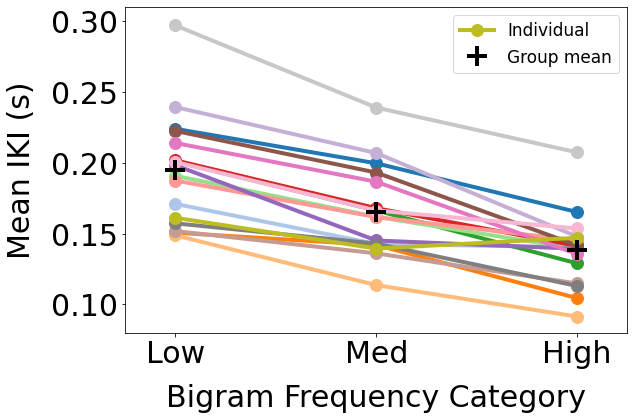

In [9]:
## individual MEAN IKI by BF (correct trials)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.31])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="best")
0
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

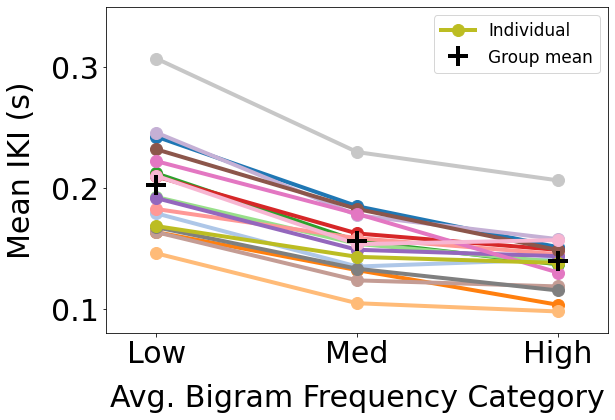

In [10]:
## individual IKI means by AVG BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'string', typ.low_avgbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.med_avgbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'string', typ.high_avgbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'string', typ.low_avgbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'string', typ.med_avgbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'string', typ.high_avgbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Avg. Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="best")
0
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

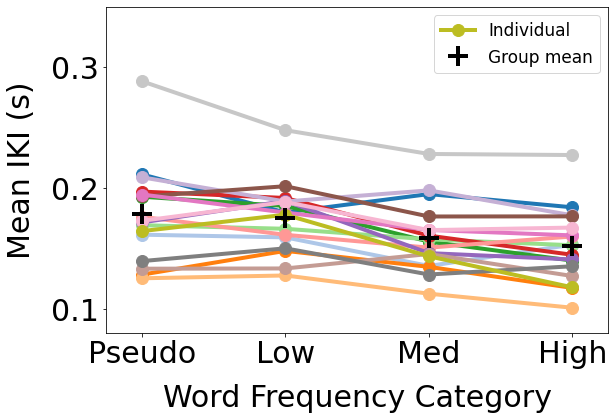

In [11]:
## individual IKI means by AVG BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6, 8]
D = (indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI'],
    indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI']),
        np.mean(indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 8.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="best")
0
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## CV GRAPHS
___

In [12]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_avgcvs(all_bigrams, 'bigram', typ.highbf),
    indiv_avgcvs(all_bigrams, 'bigram', typ.medbf).rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf).rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})

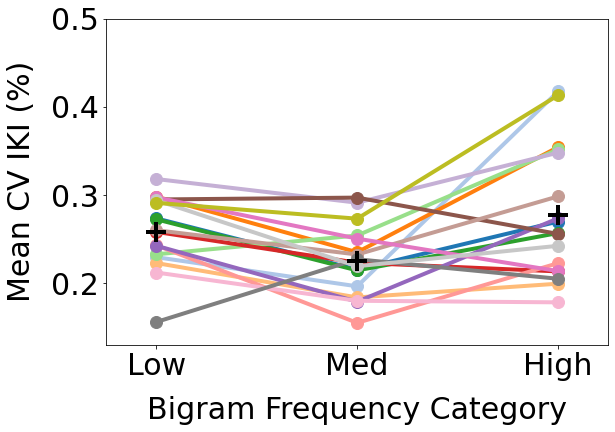

In [13]:
## Indiv. MEAN CV IKI by BF (correct trials)
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean CV IKI (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

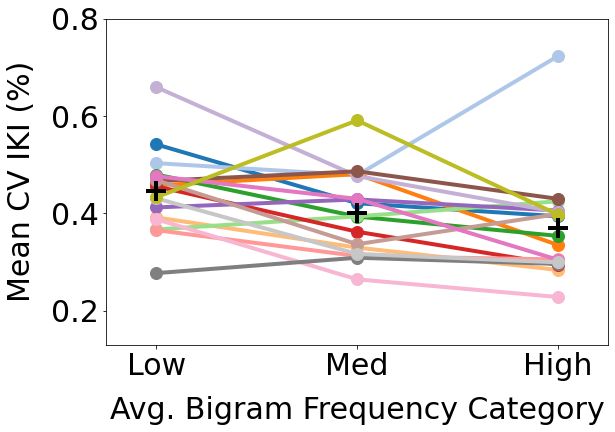

In [14]:
## Indiv. MEAN CV IKI by AVG BF (correct trials)
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'string', typ.low_avgbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.med_avgbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.high_avgbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'string', typ.low_avgbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'string', typ.med_avgbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'string', typ.high_avgbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.8])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Avg. Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean CV IKI (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

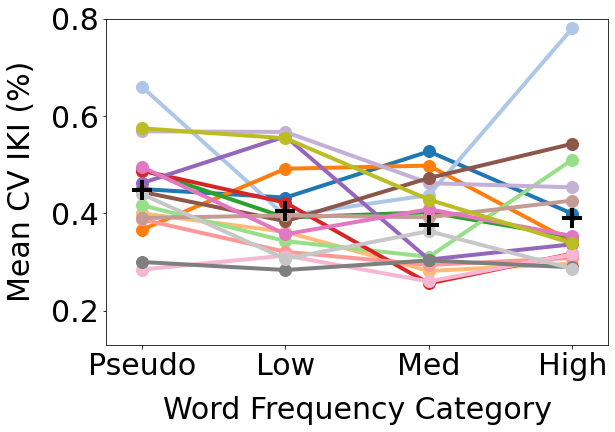

In [15]:
## Indiv. MEAN CV IKI by WF (correct trials)
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6, 8]
D = (indiv_avgcvs(corr_trials_bybg, 'string', typ.pseudo)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.lowwf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.medwf)['Avg CV IKI'],
    indiv_avgcvs(corr_trials_bybg, 'string', typ.highwf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'string', typ.pseudo)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'string', typ.lowwf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'string', typ.medwf)['Avg CV IKI']),
        np.mean(indiv_avgcvs(corr_trials_bybg, 'string', typ.highwf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 8.5])
plt.ylim([0.13, 0.8])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Mean CV IKI (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## SD GRAPHS
___

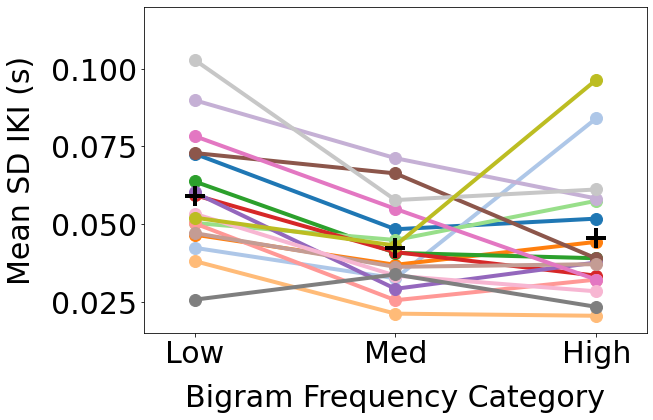

In [16]:
## individual MEAN SD IKI by BF (correct trials)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.015, 0.12])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

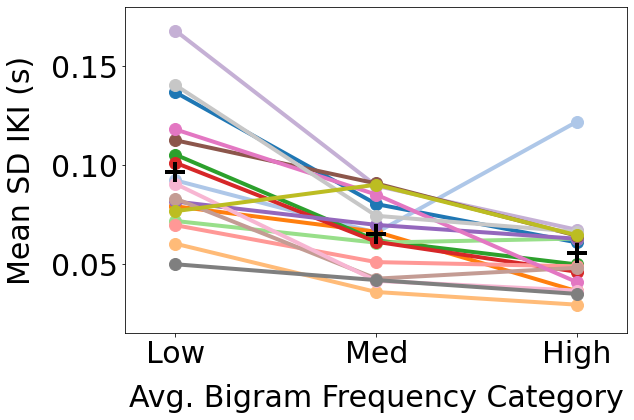

In [17]:
## individual MEAN SD IKI by BF (correct trials)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.low_avgbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.med_avgbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.high_avgbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'string', typ.low_avgbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'string', typ.med_avgbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'string', typ.high_avgbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.015, 0.18])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Avg. Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

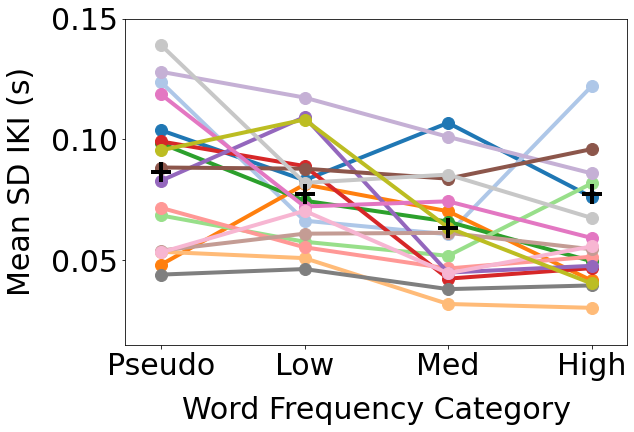

In [18]:
## individual MEAN SD IKI by BF (correct trials)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6, 8]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)['Avg SD IKI'],
    indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)['Avg SD IKI']),
        np.mean(indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 8.5])
plt.ylim([0.015, 0.15])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## ERROR GRAPHS
___

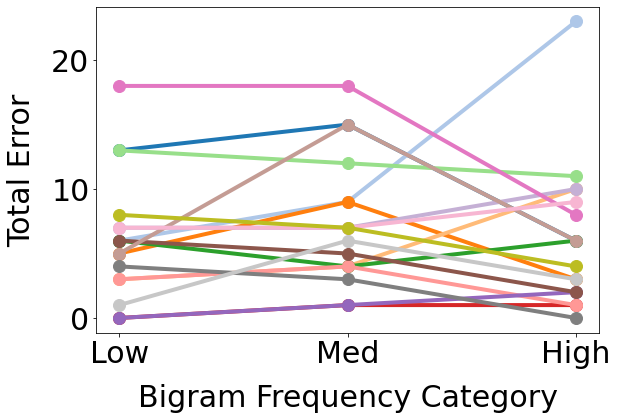

In [19]:
## individual TOTAL ERROR COUNT by BF
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error'], 
     indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error'],
     indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# plt.xlim([1.5, 6.5])
# plt.ylim([0.015, 0.12])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Total Error", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

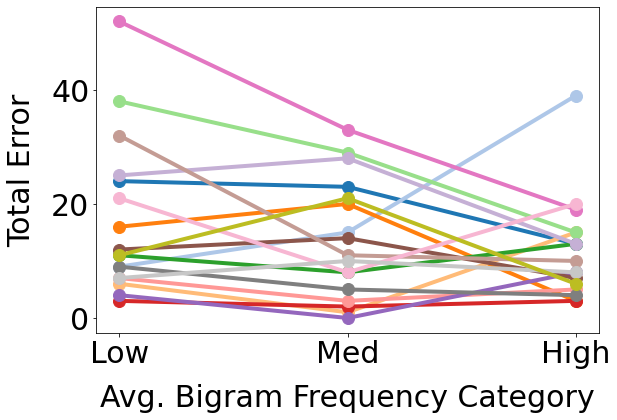

In [20]:
## individual TOTAL ERROR COUNT by BF
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'string', typ.low_avgbf)['Total Error'], 
     indiv_error(incorr_bgs, 'string', typ.med_avgbf)['Total Error'],
     indiv_error(incorr_bgs, 'string', typ.high_avgbf)['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# plt.xlim([1.5, 6.5])
# plt.ylim([0.015, 0.12])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Avg. Bigram Frequency Category", labelpad=15)
plt.ylabel("Total Error", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

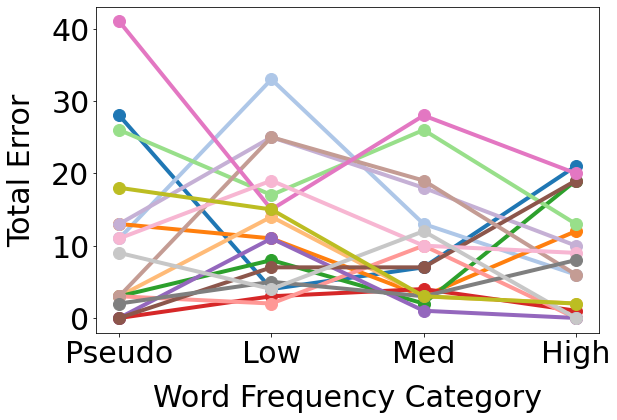

In [21]:
## individual TOTAL ERROR COUNT by BF
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6, 8]
D = (indiv_error(incorr_bgs, 'string', typ.pseudo)['Total Error'], 
     indiv_error(incorr_bgs, 'string', typ.lowwf)['Total Error'],
     indiv_error(incorr_bgs, 'string', typ.medwf)['Total Error'],
    indiv_error(incorr_bgs, 'string', typ.highwf)['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# plt.xlim([1.5, 6.5])
# plt.ylim([0.015, 0.12])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Total Error", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## Bigram-Word Interaction
___

<AxesSubplot:>

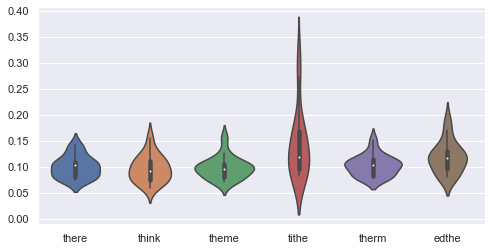

In [22]:
## distribution of 'TH' mean IKIs for each word it occurs in for all individuals
th_strings = ['there', 'think', 'theme', 'tithe', 'therm', 'edthe']
th_stuff = pd.DataFrame()
for index, ID in enumerate(ID_list):
    th_stuff.loc[index, 'sID'] = ID
    for string in th_strings:
        th_stuff.loc[index, string] = all_bigrams[(all_bigrams.sID == ID) 
                                                  & (all_bigrams.bigram == 'th') 
                                                  & (all_bigrams.string == string)]['IKI'].mean()
        
th_stuff

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=th_stuff)

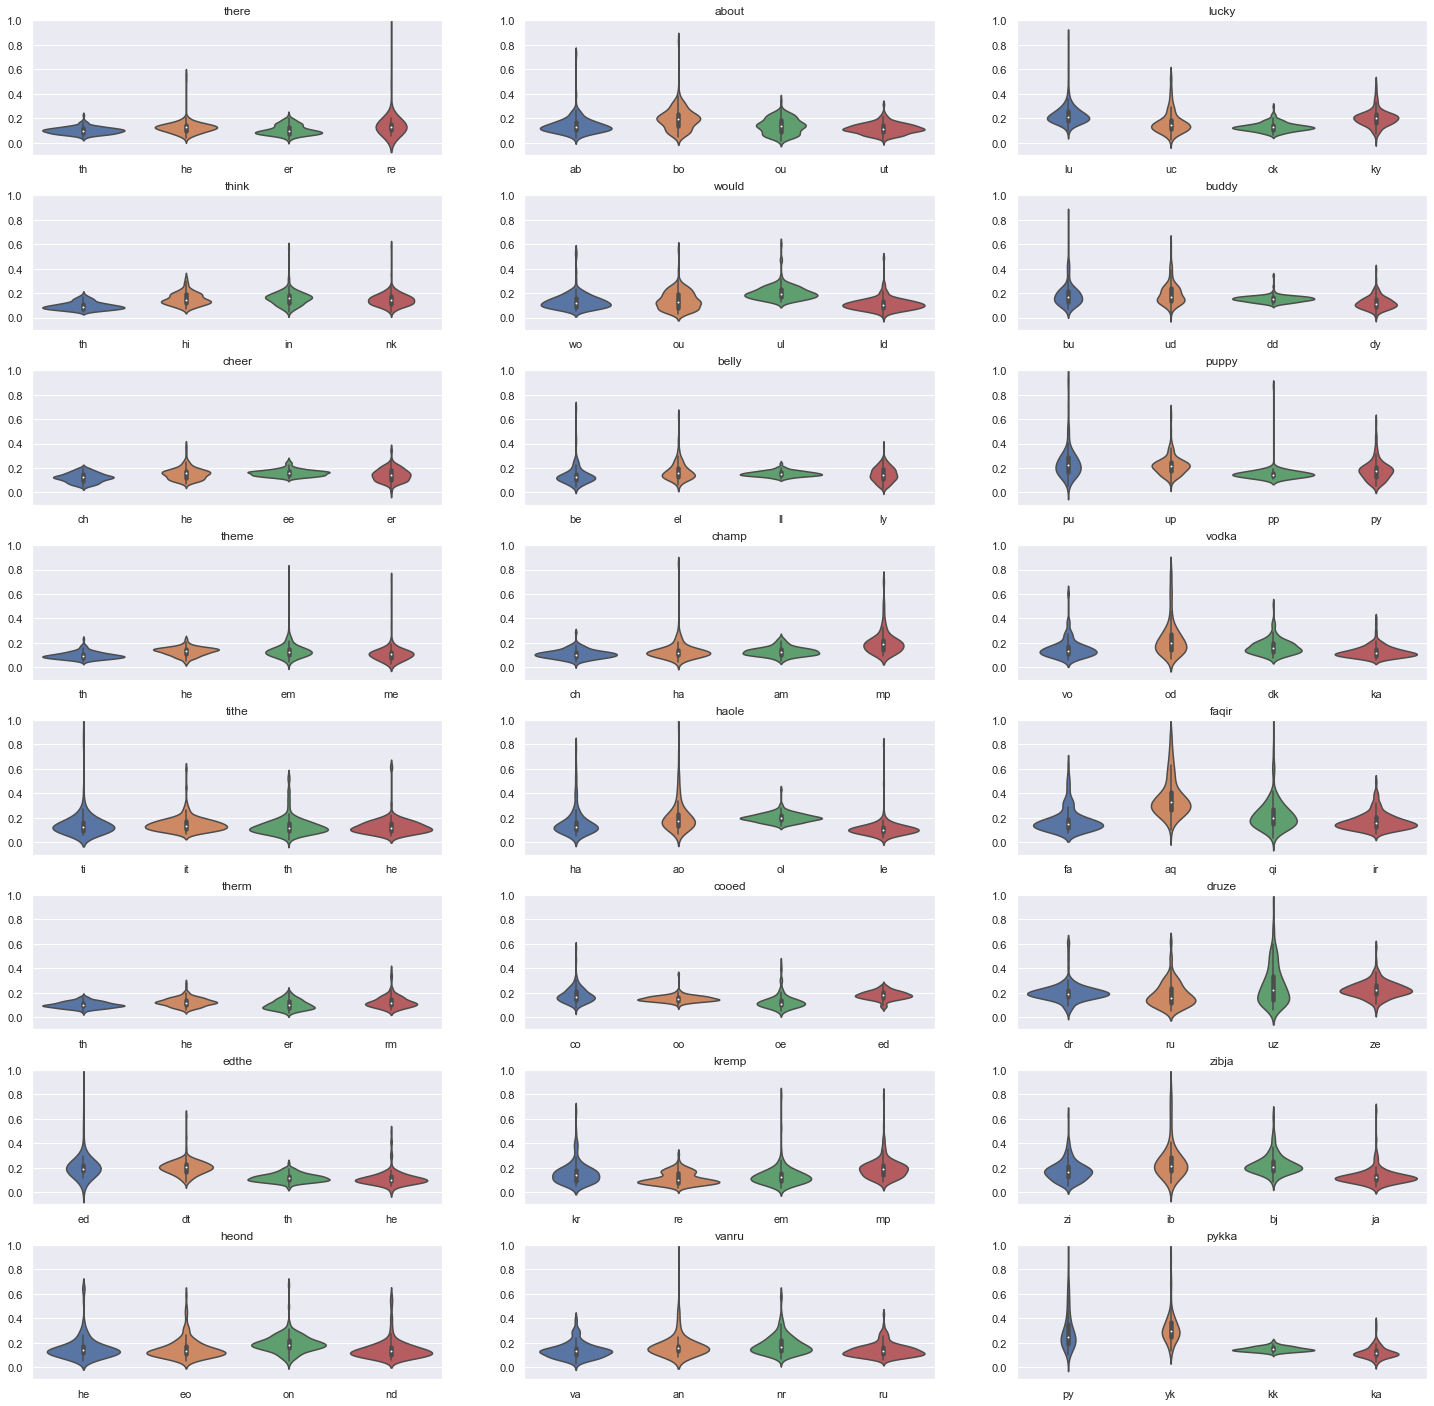

In [23]:
## plot showing iki distributions for bigrams in each word across all participants (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

# STATS
___

In [10]:
ages = [22 ,25, 20, 19, 25, 25, 26, 19, 19, 18, 25, 19, 22, 21, 19]
print(stat.mean(ages))
print(stat.stdev(ages))

21.6
2.8735244660769563


In [104]:
## anova for means (by bg freq)
high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', typ.medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     32  96.517789  2.794993e-14  0.360319  0.758628


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.136632,0.193991,-0.057359,0.011067,-5.182909,0.000013,-1.717783
1,high,med,0.136632,0.161304,-0.024672,0.011067,-2.229330,0.076389,-0.877806
2,low,med,0.193991,0.161304,0.032687,0.011067,2.953579,0.013222,0.936508


In [10]:
## anova for means (by bg freq, no reptitive bigrams)
high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', medbf_norep)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', lowbf_norep)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     32  90.449524  6.786099e-14  0.357734  0.718424


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.136632,0.197281,-0.060649,0.011787,-5.145442,0.000014,-1.738640
1,high,med,0.136632,0.161753,-0.025122,0.011787,-2.131320,0.094157,-0.838363
2,low,med,0.197281,0.161753,0.035527,0.011787,3.014122,0.011250,0.940143


In [12]:
## anova for means (by avg bg freq)
high_iki = indiv_means(corr_trials_bybg, 'string', typ.high_avgbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'string', typ.med_avgbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'string', typ.low_avgbf)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc       ng2      eps
0  bf_type      2     32  117.720049  1.765124e-15  0.402329  0.71189


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.137413,0.197145,-0.059733,0.0109,-5.480165,0.000005,-1.817849
1,high,med,0.137413,0.153027,-0.015615,0.0109,-1.432556,0.332523,-0.575033
2,low,med,0.197145,0.153027,0.044118,0.0109,4.047609,0.000541,1.267011


In [13]:
## anova for means (by word freq)
only_onebf = corr_trials_bybg[corr_trials_bybg.bf_type == 'low']

high_iki = indiv_means(only_onebf, 'string', typ.highwf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(only_onebf, 'string', typ.medwf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(only_onebf, 'string', typ.lowwf)
low_iki['bf_type'] = 'low'
pseudo_iki = indiv_means(only_onebf, 'string', typ.pseudo)
pseudo_iki['bf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      3     48  37.094483  1.488600e-12  0.318094  0.663677


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.160883,0.234976,-0.074093,0.014253,-5.198526,0.000013,-1.902458
1,high,med,0.160883,0.177694,-0.016811,0.014253,-1.179529,0.641866,-0.449782
2,high,pseudo,0.160883,0.195575,-0.034692,0.014253,-2.434071,0.080844,-0.866521
3,low,med,0.234976,0.177694,0.057281,0.014253,4.018996,0.000882,1.331595
4,low,pseudo,0.234976,0.195575,0.039401,0.014253,2.764454,0.036460,0.868880
5,med,pseudo,0.177694,0.195575,-0.017881,0.014253,-1.254542,0.594887,-0.406316


In [14]:
## anova for cvs (by bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F    p-unc       ng2       eps
0  bf_type      2     32  7.474323  0.00217  0.192115  0.767829


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.274294,0.255299,0.018995,0.017832,1.065193,0.540056,0.322347
1,high,med,0.274294,0.215282,0.059011,0.017832,3.309257,0.004974,1.038456
2,low,med,0.255299,0.215282,0.040017,0.017832,2.244065,0.073978,1.066765


In [11]:
## anova for cvs (by bg freq, no reptitive bigrams)
high_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', medbf_norep)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', lowbf_norep)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bf_type      2     32  4.773243  0.015341  0.132524  0.793086


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.274294,0.269307,0.004986,0.018324,0.272118,0.960037,0.083315
1,high,med,0.274294,0.229045,0.045248,0.018324,2.469330,0.044422,0.782196
2,low,med,0.269307,0.229045,0.040262,0.018324,2.197211,0.081874,0.996040


In [15]:
## anova for cvs (by avg bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.high_avgbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.med_avgbf)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.low_avgbf)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bf_type      2     32  4.379139  0.020842  0.092338  0.937031


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.368980,0.434253,-0.065273,0.02993,-2.180860,0.084790,-0.735558
1,high,med,0.368980,0.392380,-0.023400,0.02993,-0.781827,0.715896,-0.240616
2,low,med,0.434253,0.392380,0.041873,0.02993,1.399033,0.349446,0.564074


In [12]:
## anova for sds (by bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2      eps
0  bf_type      2     32  7.814621  0.001724  0.187589  0.66204


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.044397,0.057243,-0.012846,0.00573,-2.241916,0.074326,-0.678611
1,high,med,0.044397,0.038607,0.005790,0.00573,1.010455,0.573943,0.352699
2,low,med,0.057243,0.038607,0.018636,0.00573,3.252370,0.005842,1.287839


In [13]:
## anova for sds (by bg freq, no reptitive bigrams)
high_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2      eps
0  bf_type      2     32  9.203598  0.000696  0.203643  0.65092


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.044397,0.060832,-0.016435,0.006069,-2.707794,0.024917,-0.839963
1,high,med,0.044397,0.040929,0.003468,0.006069,0.571389,0.835937,0.201555
2,low,med,0.060832,0.040929,0.019903,0.006069,3.279183,0.005416,1.233176


In [17]:
## anova for sds (by avg bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.high_avgbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.med_avgbf)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.low_avgbf)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     32  23.473459  5.309293e-07  0.366077  0.837453


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,0.054053,0.091146,-0.037093,0.007401,-5.012018,0.000023,-1.598643
1,high,med,0.054053,0.062268,-0.008215,0.007401,-1.109964,0.512682,-0.419564
2,low,med,0.091146,0.062268,0.028878,0.007401,3.902055,0.000853,1.325060


In [18]:
## anova for error rates (by bg freq)
high_err = indiv_error(incorr_bgs, 'bigram', typ.highbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_bgs, 'bigram', typ.medbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_bgs, 'bigram', typ.lowbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  bf_type      2     32  0.295543  0.746136   0.656152  0.006152  0.661762   

   sphericity   W-spher   p-spher  
0       False  0.488883  0.004667  


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,5.941176,6.647059,-0.705882,1.713051,-0.412061,0.910833,-0.134544
1,high,med,5.941176,6.823529,-0.882353,1.713051,-0.515077,0.864381,-0.176536
2,low,med,6.647059,6.823529,-0.176471,1.713051,-0.103015,0.994167,-0.037350


In [19]:
## anova for error rates (by avg bg freq)
high_err = indiv_error(incorr_trials, 'string', typ.high_avgbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_trials, 'string', typ.med_avgbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_trials, 'string', typ.low_avgbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2        F     p-unc       ng2       eps
0  bf_type      2     32  1.94209  0.159938  0.035027  0.757454


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,4.705882,6.411765,-1.705882,1.294675,-1.317615,0.392482,-0.466639
1,high,med,4.705882,5.470588,-0.764706,1.294675,-0.590655,0.825775,-0.223157
2,low,med,6.411765,5.470588,0.941176,1.294675,0.726960,0.748804,0.224115


In [21]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')
skew_df

,sID,skew,mean IKI
0,s20,4.537099,0.135337
1,s175,2.812225,0.191252
2,s178,9.766887,0.155502
3,s180,3.704217,0.132674
4,s181,4.930082,0.116986
5,s182,2.506407,0.169157
6,s183,4.123232,0.160179
7,s189,3.283803,0.173022
8,s190,2.493626,0.161795
9,s198,3.385264,0.160854
